# Example demonstrating compositional flow
This is a simple conceptual example demonstrating how to solve compositional
flow. This example uses a two-component water-CO2 system. Note that the
default Peng-Robinson is not accurate for this system without adjustments to
the parameters. However, the example demonstrates the conceptual workflow for
getting started with compositional simulation.
## Set up mixture
We load the external flash package and define a two-component H2O-CO2 system.
The constructor for each species takes in molecular weight, critical pressure,
critical temperature, critical volume, acentric factor given as strict SI.
This means, for instance, that molar masses are given in kg/mole and not
g/mole or kg/kmol.

In [1]:
using MultiComponentFlash
h2o = MolecularProperty(0.018015268, 22.064e6, 647.096, 5.595e-05, 0.3442920843)
co2 = MolecularProperty(0.0440098, 7.3773e6, 304.1282, 9.412e-05, 0.22394)

bic = zeros(2, 2)

mixture = MultiComponentMixture([h2o, co2], A_ij = bic, names = ["H2O", "CO2"])
eos = GenericCubicEOS(mixture, PengRobinson())

MultiComponentFlash.GenericCubicEOS{MultiComponentFlash.PengRobinson, Float64, 2, Nothing}(MultiComponentFlash.PengRobinson(), MultiComponentFlash.MultiComponentMixture{Float64, 2}("UnnamedMixture", ["H2O", "CO2"], (MultiComponentFlash.MolecularProperty{Float64}(0.018015268, 2.2064e7, 647.096, 5.595e-5, 0.3442920843), MultiComponentFlash.MolecularProperty{Float64}(0.0440098, 7.3773e6, 304.1282, 9.412e-5, 0.22394)), [0.0 0.0; 0.0 0.0]), 2.414213562373095, -0.41421356237309515, 0.457235529, 0.077796074, nothing)

## Set up domain and wells

In [2]:
using Jutul, JutulDarcy, GLMakie
nx = 50
ny = 1
nz = 20
dims = (nx, ny, nz)
g = CartesianMesh(dims, (100.0, 10.0, 10.0))
nc = number_of_cells(g)
Darcy, bar, kg, meter, Kelvin, day, sec = si_units(:darcy, :bar, :kilogram, :meter, :Kelvin, :day, :second)
K = repeat([0.1, 0.1, 0.001]*Darcy, 1, nc)
res = reservoir_domain(g, porosity = 0.3, permeability = K)

DataDomain wrapping CartesianMesh (3D) with 50x1x20=1000 cells with 17 data fields added:
  1000 Cells
    :permeability => 3×1000 Matrix{Float64}
    :porosity => 1000 Vector{Float64}
    :rock_thermal_conductivity => 1000 Vector{Float64}
    :fluid_thermal_conductivity => 1000 Vector{Float64}
    :rock_density => 1000 Vector{Float64}
    :cell_centroids => 3×1000 Matrix{Float64}
    :volumes => 1000 Vector{Float64}
  1930 Faces
    :neighbors => 2×1930 Matrix{Int64}
    :areas => 1930 Vector{Float64}
    :normals => 3×1930 Matrix{Float64}
    :face_centroids => 3×1930 Matrix{Float64}
  3860 HalfFaces
    :half_face_cells => 3860 Vector{Int64}
    :half_face_faces => 3860 Vector{Int64}
  2140 BoundaryFaces
    :boundary_areas => 2140 Vector{Float64}
    :boundary_centroids => 3×2140 Matrix{Float64}
    :boundary_normals => 3×2140 Matrix{Float64}
    :boundary_neighbors => 2140 Vector{Int64}


Set up a vertical well in the first corner, perforated in top layer

In [3]:
prod = setup_well(g, K, [(nx, ny, 1)], name = :Producer)

MultiSegmentWell [Producer] (2 nodes, 1 segments, 1 perforations)

Set up an injector in the opposite corner, perforated in bottom layer

In [4]:
inj = setup_well(g, K, [(1, 1, nz)], name = :Injector)

MultiSegmentWell [Injector] (2 nodes, 1 segments, 1 perforations)

## Define system and realize on grid

In [5]:
rhoLS = 844.23*kg/meter^3
rhoVS = 126.97*kg/meter^3
rhoS = [rhoLS, rhoVS]
L, V = LiquidPhase(), VaporPhase()
sys = MultiPhaseCompositionalSystemLV(eos, (L, V))
model, parameters = setup_reservoir_model(res, sys, wells = [inj, prod]);
push!(model[:Reservoir].output_variables, :Saturations)
kr = BrooksCoreyRelativePermeabilities(sys, 2.0, 0.0, 1.0)
model = replace_variables!(model, RelativePermeabilities = kr)
T0 = repeat([303.15*Kelvin], 1, nc)
parameters[:Reservoir][:Temperature] = T0
state0 = setup_reservoir_state(model, Pressure = 50*bar, OverallMoleFractions = [1.0, 0.0]);

## Define schedule
5 year (5*365.24 days) simulation period

In [6]:
dt0 = repeat([1]*day, 26)
dt1 = repeat([10.0]*day, 180)
dt = append!(dt0, dt1)
rate_target = TotalRateTarget(9.5066e-06*meter^3/sec)
I_ctrl = InjectorControl(rate_target, [0, 1], density = rhoVS)
bhp_target = BottomHolePressureTarget(50*bar)
P_ctrl = ProducerControl(bhp_target)

controls = Dict()
controls[:Injector] = I_ctrl
controls[:Producer] = P_ctrl
forces = setup_reservoir_forces(model, control = controls)
ws, states = simulate_reservoir(state0, model, dt, parameters = parameters, forces = forces)

Simulating 4 years, 52.15 weeks as 206 report steps   1%  ETA: 0:17:04
  Progress:  Solving step 2/206 (0.11% of time interval complete)


Simulating 4 years, 52.15 weeks as 206 report steps   5%  ETA: 0:03:00
  Progress:  Solving step 11/206 (0.60% of time interval complete)


Simulating 4 years, 52.15 weeks as 206 report steps  11%  ETA: 0:01:26
  Progress:  Solving step 22/206 (1.20% of time interval complete)


Simulating 4 years, 52.15 weeks as 206 report steps  15%  ETA: 0:00:59
  Progress:  Solving step 31/206 (4.16% of time interval complete)


Simulating 4 years, 52.15 weeks as 206 report steps  18%  ETA: 0:00:46
  Progress:  Solving step 38/206 (8.00% of time interval complete)


Simulating 4 years, 52.15 weeks as 206 report steps  21%  ETA: 0:00:39
  Progress:  Solving step 44/206 (11.28% of time interval complete)


Simulating 4 years, 52.15 weeks as 206 report steps  24%  ETA: 0:00:34
  Progress:  Solving step 50/206 (14.57% of time interval complete)


Simulating 4 years,

ReservoirSimResult with 206 entries:

  wells (2 present):
    :Producer
    :Injector
    Results per well:
       :H2O_mass_rate => Vector{Float64} of size (206,)
       :lrat => Vector{Float64} of size (206,)
       :orat => Vector{Float64} of size (206,)
       :control => Vector{Symbol} of size (206,)
       :bhp => Vector{Float64} of size (206,)
       :CO2_mass_rate => Vector{Float64} of size (206,)
       :mass_rate => Vector{Float64} of size (206,)
       :rate => Vector{Float64} of size (206,)
       :grat => Vector{Float64} of size (206,)

  states (Vector with 206 entries, reservoir variables for each state)
    :LiquidMassFractions => Matrix{Float64} of size (2, 1000)
    :OverallMoleFractions => Matrix{Float64} of size (2, 1000)
    :Saturations => Matrix{Float64} of size (2, 1000)
    :Pressure => Vector{Float64} of size (1000,)
    :VaporMassFractions => Matrix{Float64} of size (2, 1000)
    :TotalMasses => Matrix{Float64} of size (2, 1000)

  time (report time for each

## Once the simulation is done, we can plot the states
Note that this example is intended for static publication in the
documentation. For interactive visualization you can use functions like
`plot_interactive` to interactively visualize the states.

In [7]:
z = states[end][:OverallMoleFractions][2, :]
function plot_vertical(x, t)
    data = reshape(x, (nx, nz))
    data = data[:, end:-1:1]
    fig, ax, plot = heatmap(data)
    ax.title = t
    Colorbar(fig[1, 2], plot)
    fig
end

plot_vertical (generic function with 1 method)

### Plot final CO2 mole fraction

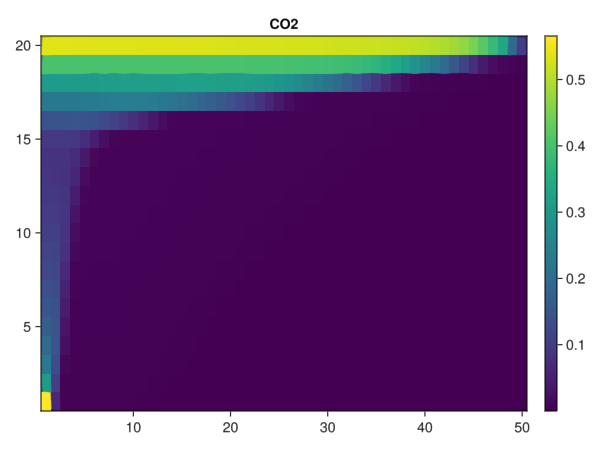

In [8]:
plot_vertical(z, "CO2")

### Plot final vapor saturation

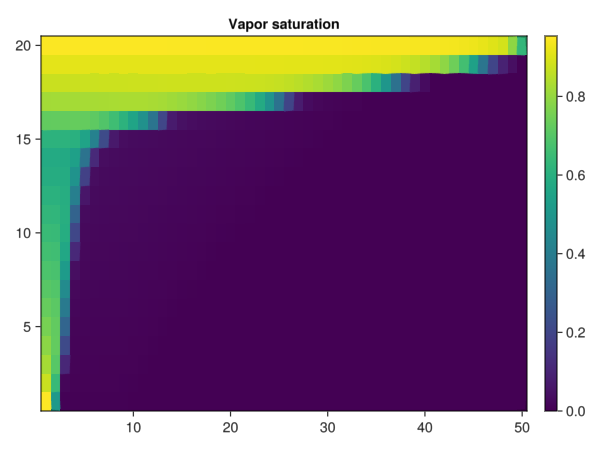

In [9]:
sg = states[end][:Saturations][2, :]
plot_vertical(sg, "Vapor saturation")

### Plot final pressure

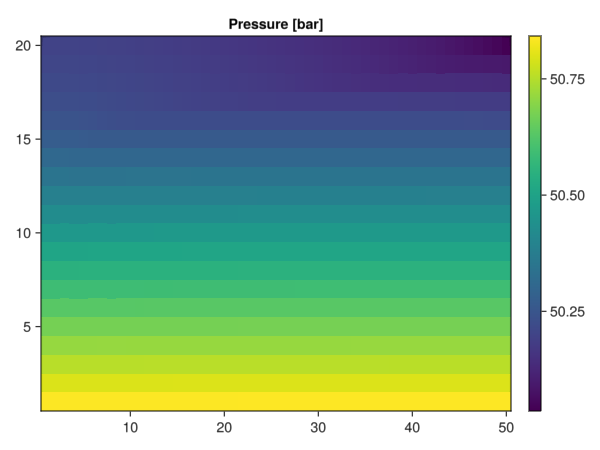

In [10]:
p = states[end][:Pressure]
plot_vertical(p./bar, "Pressure [bar]")

### Plot in interactive viewer

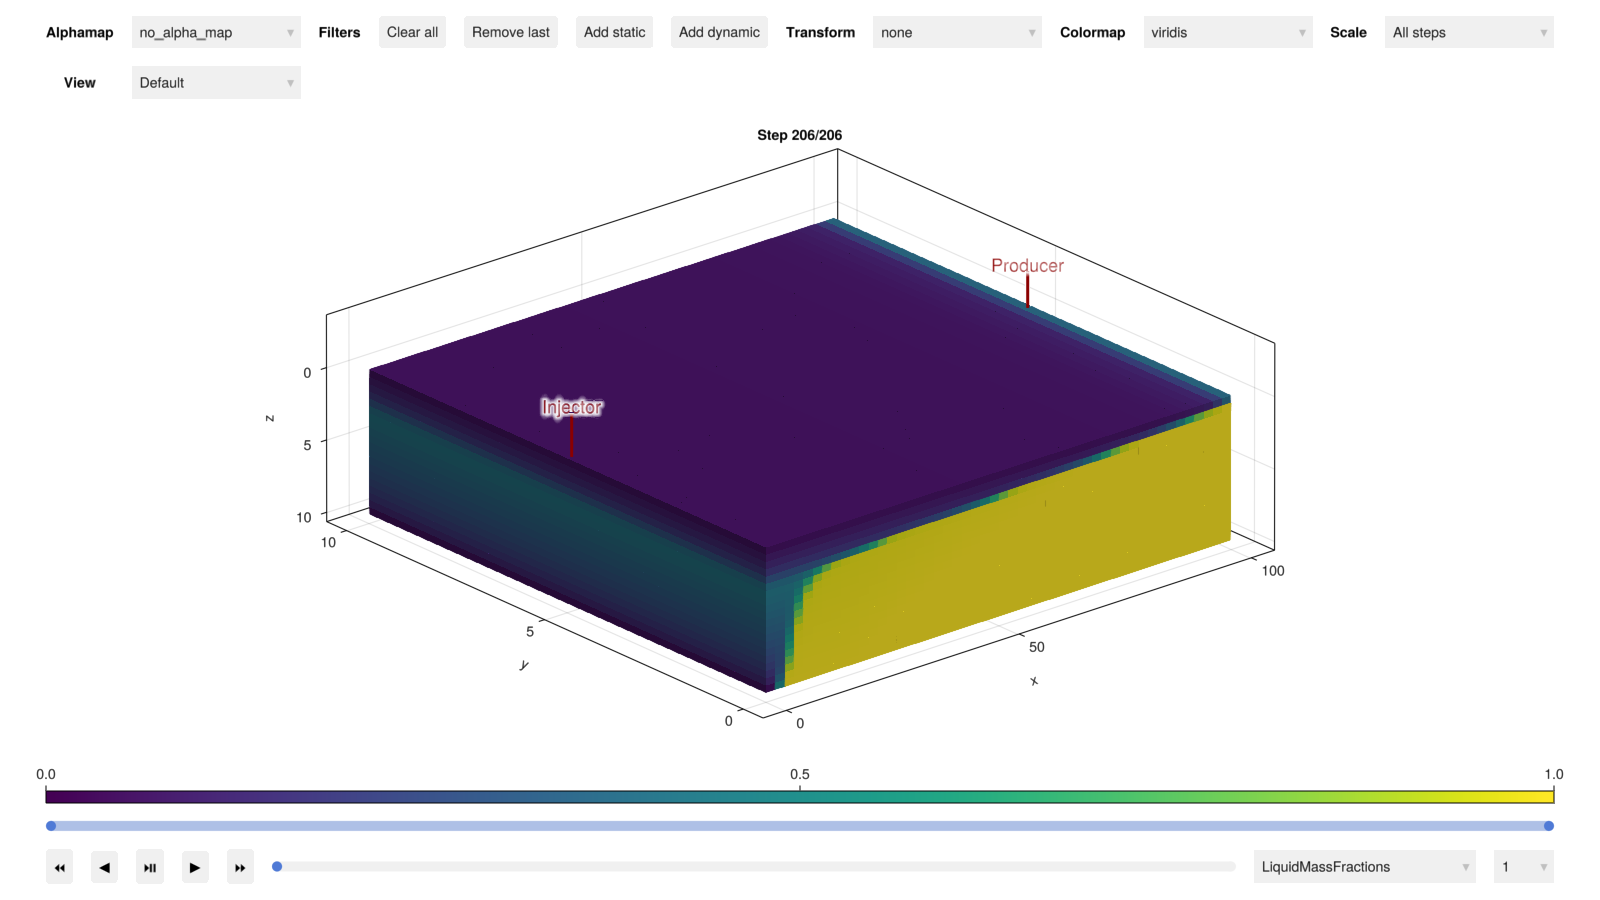

In [11]:
plot_reservoir(model, states, step = length(dt), key = :Saturations)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*